In [23]:
from DatasetLoader import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print ('Running on: {}'.format(device))

thresh = 0.3
batch_size = 256 # default 256
time_window = 200 # shd 50, nmnist 25-30
dataset_path = r'./../../datasets'

test_path = dataset_path+'/shd_digits/shd_test.h5'
# load datasets
print("loading test set...")
test_dataset = DatasetLoader(test_path, 'shd', time_window, device)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)
print("done")

Running on: cpu
loading test set...
num sample: 2264
torch.Size([2264, 200, 700]) torch.Size([2264, 20])
done


In [24]:
from snn_models_monitor import *
%load_ext autoreload
%autoreload 1
%aimport snn_models_monitor

tau_m = 'adp'
#tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn = RSNN_monitor('shd', num_hidden=64, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RSNN_monitor(
  (fc_ih): Linear(in_features=700, out_features=64, bias=False)
  (fc_hh): Linear(in_features=64, out_features=64, bias=False)
  (fc_ho): Linear(in_features=64, out_features=20, bias=False)
  (i_drop): Dropout(p=0.1, inplace=False)
)

In [25]:
# train step
num_samples = test_dataset.images.size()[0]
base_params = [getattr(snn,name.split('.')[0]).weight for name, _ in snn.state_dict().items() if name[0]=='f']
optimizer = torch.optim.Adam([
    {'params': base_params}],
    lr=1e-3)
    
snn.train_step(test_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples =num_samples)

Step [2/8], Loss: 0.09980
Step [4/8], Loss: 0.09768
Step [6/8], Loss: 0.09742
Step [8/8], Loss: 0.09643


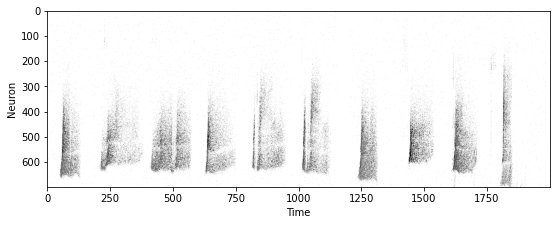

In [26]:
fig = snn.plot_activity('x','spike','normal', range(10))

[335.0, 40.50606]


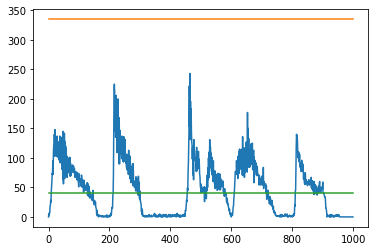

In [27]:
# check density of input spikes 
input_spike = test_dataset.images.reshape(-1, test_dataset.images.shape[-1]).sum(axis=1).cpu().numpy()
print([input_spike.max(), input_spike.mean()])
i_s = input_spike[:1000]
t = len(i_s)
plt.figure()
plt.plot(i_s)
plt.plot(np.arange(t), input_spike.max()*np.ones(t))
plt.plot(np.arange(t), input_spike.mean()*np.ones(t))
plt.show()